# Manuscript Figures
Created by Ivan Lima on Wed Jan 26 2022 10:51:31 -0500

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings, cmocean
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Mar  8 10:49:52 2022


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Distribution of bottle data 

In [3]:
# read bottle data
df_bottle = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df_bottle.loc[df_bottle.Date.dt.month.isin([1,2,12]),'season'] = 'Winter' # set seasons
df_bottle.loc[df_bottle.Date.dt.month.isin([3,4,5]),'season'] = 'Spring'
df_bottle.loc[df_bottle.Date.dt.month.isin([6,7,8]),'season'] = 'Summer'
df_bottle.loc[df_bottle.Date.dt.month.isin([9,10,11]),'season'] = 'Fall'

# read bottom topography data
etopo = xr.open_dataset('data/etopo5.nc', chunks='auto')
etopo['bath'] = etopo.bath.where(etopo.bath<0) # ocean points only
etopo = etopo.isel(X=slice(3100,4000), Y=slice(1300,1700)) # subset data to make things faster

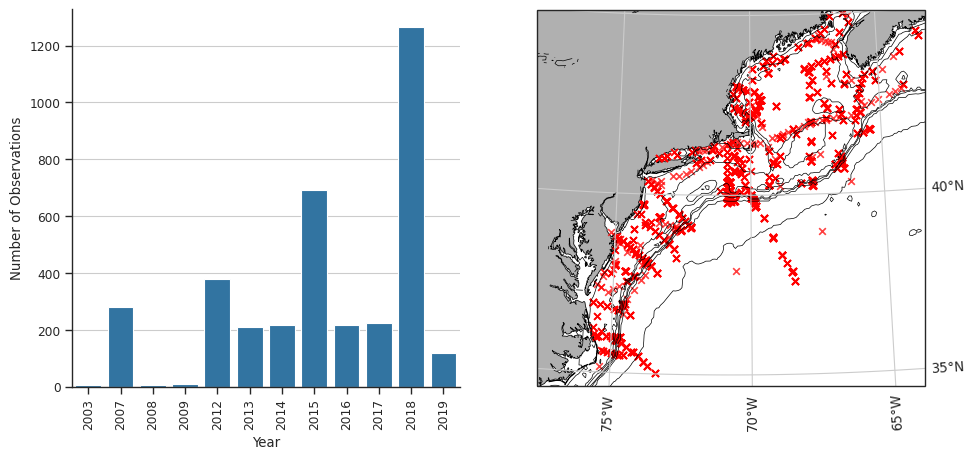

In [4]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

minlon, maxlon = 282.5, 296
minlat, maxlat =  34.5, 45
lonc, latc = (minlon + maxlon)/2., (minlat + maxlat)/2.
isobaths = [-10, -50, -100, -250, -500, -1000, -3000]
proj = ccrs.EquidistantConic(central_longitude=lonc, central_latitude=latc)
dpi = 600

s_bottle = df_bottle.groupby('Year')['TA'].count().to_frame().reset_index()

fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(1,2,1)
_ = sns.barplot(data=s_bottle, x='Year', y='TA', color='C0', ax=ax1)
_ = ax1.set_xticklabels(s_bottle.Year, rotation=90)
_ = ax1.set(ylabel='Number of Observations')
sns.despine(fig)
ax2 = fig.add_subplot(1,2,2, projection=proj)
ax2.set_extent([minlon,maxlon,minlat,maxlat])
_ = ax2.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
_ = ax2.coastlines(linewidth=0.5, zorder=1)
_ = ax2.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x', 'right': 'y'})
sp = ax2.scatter(df_bottle.Longitude, df_bottle.Latitude, c='red', marker='x', transform=ccrs.PlateCarree(), alpha=0.75)
cs = ax2.contour(etopo.X, etopo.Y, etopo.bath, isobaths[::-1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# _ = ax2.clabel(cs, isobaths, fontsize=7)
# fig.savefig('figures/bottle_data_distribution.png', dpi=dpi, bbox_inches='tight')

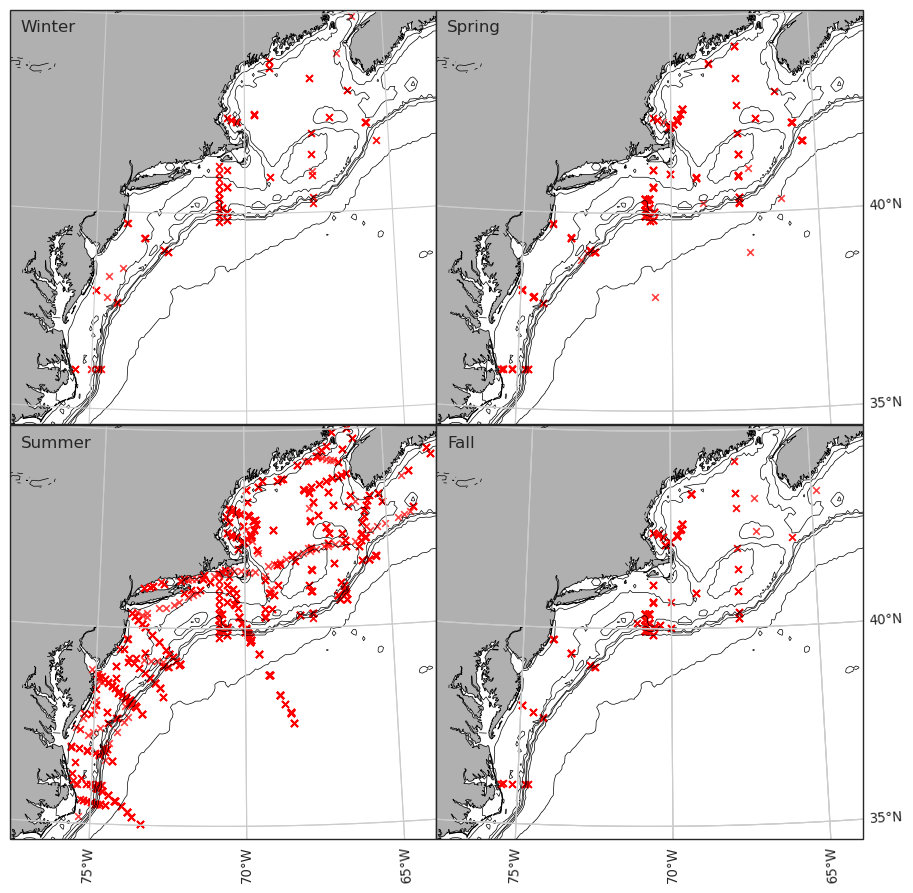

In [5]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection':proj}, figsize=(11,11))
fig.subplots_adjust(hspace=0, wspace=0)

for ax, s in zip(axs.ravel(), ['Winter','Spring','Summer','Fall']):
    ax.set_extent([minlon,maxlon,minlat,maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths[::-1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
    df = df_bottle[df_bottle.season==s]
    _ = ax.scatter(df.Longitude, df.Latitude, c='red', marker='x', transform=ccrs.PlateCarree(), alpha=0.75)
    _ = ax.text(0.025, 0.975, s, ha='left', va='top', transform=ax.transAxes, fontsize=12)

for ax in axs[:,-1]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})

for ax in axs[-1,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})

fig.savefig('figures/bottle_data_distribution_seasonal.png', dpi=dpi, bbox_inches='tight')

## Distribution of CTD data 

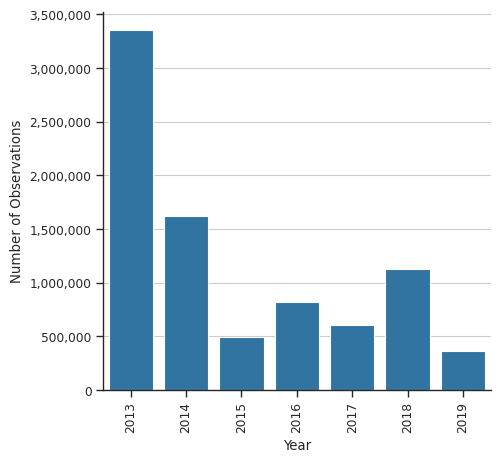

In [6]:
from matplotlib import ticker
fmt = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))

df_wod = pd.read_hdf('data/bgc_all_2013-2019.h5', key='df_wod_bgc')
s_ctd = df_wod.groupby(df_wod.Date.dt.year)['TA'].count().to_frame().reset_index()

fig, ax = plt.subplots()
_ = sns.barplot(data=s_ctd, x='Date', y='TA', color='C0', ax=ax)
_ = ax.set_xticklabels(s_ctd.Date, rotation=90)
_ = ax.set(xlabel='Year', ylabel='Number of Observations')
_ = ax.yaxis.set_major_formatter(fmt)
sns.despine(fig)
# fig.savefig('figures/ctd_data_distribution_time.png', dpi=dpi, bbox_inches='tight')

In [7]:
df_ctd = pd.read_csv('data/CombinedCTD_metadata_bathy_600m_sorted.csv', parse_dates=['Date'], index_col=0)
df_ctd = df_ctd[df_ctd.Year>2012]
df_ctd = df_ctd[df_ctd.Longitude<-64.5]  # NELME region
df_ctd = df_ctd[df_ctd.Longitude>-76]    # exclude points in Chesapeake Bay 
df_ctd = df_ctd[df_ctd.Platform_Type!=2] # exclude glider data
df_ctd.loc[df_ctd.Date.dt.month.isin([1,2,12]),'season'] = 'Winter' # set seasons
df_ctd.loc[df_ctd.Date.dt.month.isin([3,4,5]),'season'] = 'Spring'
df_ctd.loc[df_ctd.Date.dt.month.isin([6,7,8]),'season'] = 'Summer'
df_ctd.loc[df_ctd.Date.dt.month.isin([9,10,11]),'season'] = 'Fall'
# df_ctd.head()

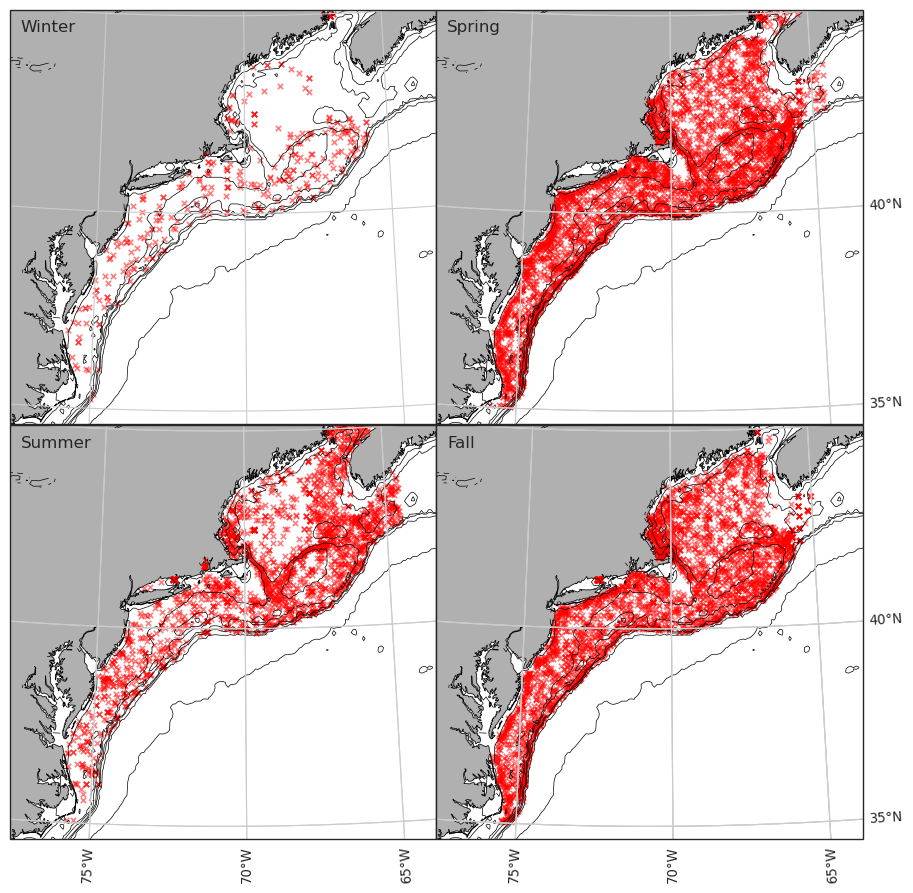

In [8]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection':proj}, figsize=(11,11))
fig.subplots_adjust(hspace=0, wspace=0)

for ax, s in zip(axs.ravel(), ['Winter','Spring','Summer','Fall']):
    ax.set_extent([minlon,maxlon,minlat,maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths[::-1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
    df = df_ctd[df_ctd.season==s]
    _ = ax.scatter(df.Longitude, df.Latitude, c='red', s=15, marker='x', transform=ccrs.PlateCarree(), alpha=0.5)
    _ = ax.text(0.025, 0.975, s, ha='left', va='top', transform=ax.transAxes, fontsize=12)

for ax in axs[:,-1]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})

for ax in axs[-1,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})

fig.savefig('figures/ctd_data_distribution_seasonal.png', dpi=dpi, bbox_inches='tight')

In [9]:
# import hvplot.pandas
# import holoviews as hv
# from my_bokeh_themes import *

# # df_ctd.hvplot.points('Longitude', 'Latitude', geo=True, coastline='50m', features={'land':'50m'},
# #                      frame_width=400, rasterize=True)

# p_ctd = hv.Layout()
# for season in ['Winter','Spring','Summer','Fall']:
#     df = df_ctd[df_ctd.season==season]
#     print(season, len(df))
#     p = df.hvplot.points('Longitude', 'Latitude', geo=True, coastline='50m', features={'land':'50m'},
#                          frame_width=400, rasterize=False)
#     p_ctd += p

# p_ctd.cols(2)

## Temporal distribution of bottle & CTD data

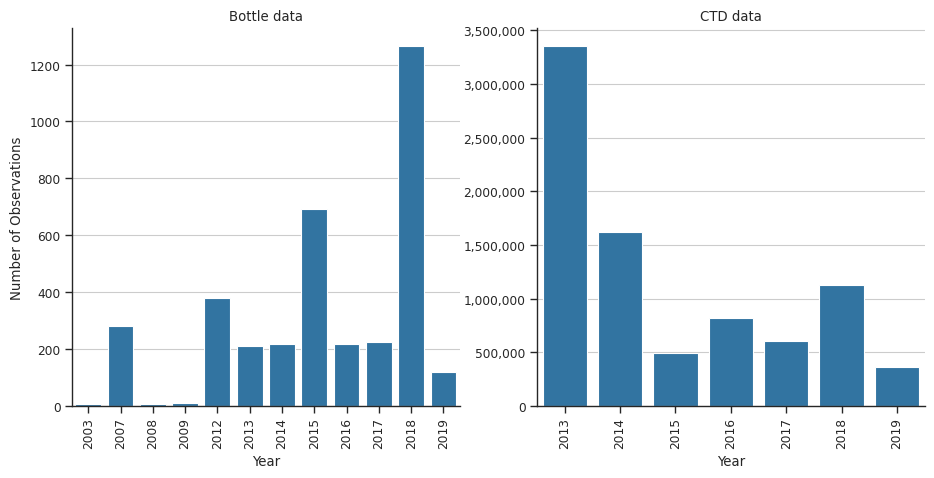

In [10]:
s_bottle = df_bottle.groupby('Year')['TA'].count().to_frame().reset_index()
s_ctd = df_wod.groupby(df_wod.Date.dt.year)['TA'].count().to_frame().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.barplot(data=s_bottle, x='Year', y='TA', color='C0', ax=axs[0])
_ = axs[0].set_xticklabels(s_bottle.Year, rotation=90)
_ = axs[0].set(ylabel='Number of Observations', title='Bottle data')
_ = sns.barplot(data=s_ctd, x='Date', y='TA', color='C0', ax=axs[1])
_ = axs[1].set_xticklabels(s_ctd.Date, rotation=90)
_ = axs[1].set(xlabel='Year', ylabel='', title='CTD data')
_ = axs[1].yaxis.set_major_formatter(fmt)
sns.despine(fig)
fig.savefig('figures/data_distribution_time.png', dpi=dpi, bbox_inches='tight')

## Seasonal maps

### Surface fields

In [11]:
ds_surface = xr.open_dataset('data/bgc_surface_seasonal.nc')
ds_surface.data_vars

Data variables:
    Temperature           (season, lat, lon) float64 ...
    Salinity              (season, lat, lon) float64 ...
    DIC                   (season, lat, lon) float64 ...
    TA                    (season, lat, lon) float64 ...
    pH                    (season, lat, lon) float64 ...
    pCO2                  (season, lat, lon) float64 ...
    fCO2                  (season, lat, lon) float64 ...
    saturation_calcite    (season, lat, lon) float64 ...
    saturation_aragonite  (season, lat, lon) float64 ...

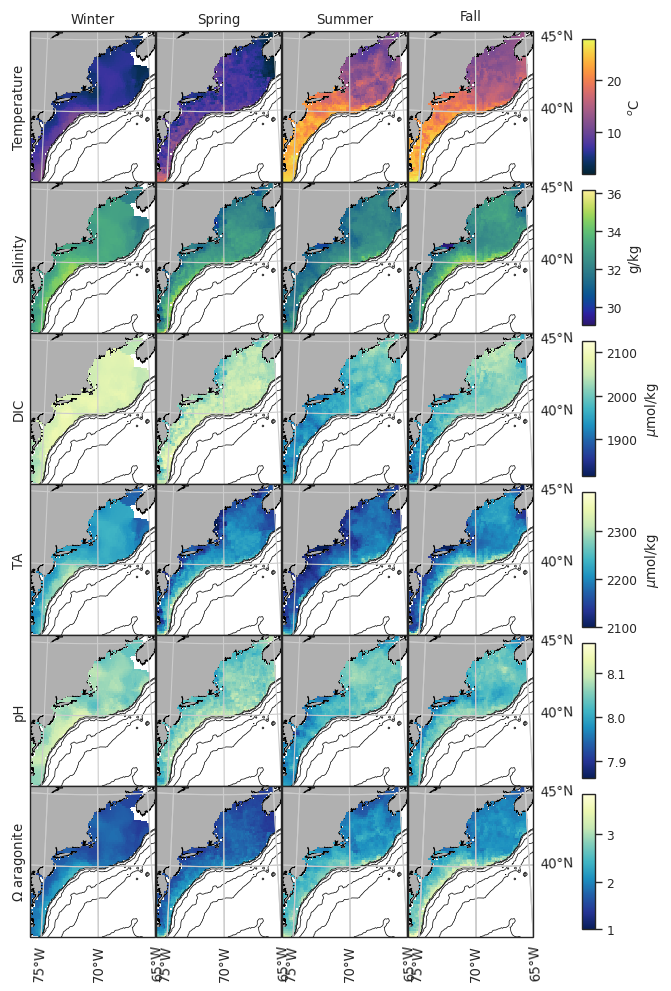

In [12]:
minlon, maxlon = ds_surface.lon.min().values, ds_surface.lon.max().values
minlat, maxlat =  ds_surface.lat.min().values, ds_surface.lat.max().values
lonc, latc = (minlon + maxlon)/2., (minlat + maxlat)/2.
proj = ccrs.EquidistantConic(central_longitude=lonc, central_latitude=latc)
cmap = plt.cm.YlGnBu_r

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(6.5, 12), subplot_kw={'projection':proj})
fig.subplots_adjust(hspace=0, wspace=0)
for ax in axs.ravel():
    ax.set_extent([minlon,maxlon,minlat,maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, [-5000, -4000, -3000, -2000, -1000, -600],
                   colors='k', linewidths=0.5, transform=ccrs.PlateCarree())

for s in range(4):
    tem = axs[0,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.Temperature.isel(season=s),
                              vmin=1.75, vmax=28, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
    sal = axs[1,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.Salinity.isel(season=s),
                              vmin=29, vmax=36.2, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())
    dic = axs[2,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.DIC.isel(season=s),
                              vmin=1815, vmax=2126, cmap=cmap, transform=ccrs.PlateCarree())
    ta  = axs[3,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.TA.isel(season=s),
                              vmin=2099, vmax=2381.2, cmap=cmap, transform=ccrs.PlateCarree())
    ph  = axs[4,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.pH.isel(season=s),
                              vmin=7.86, vmax=8.17, cmap=cmap, transform=ccrs.PlateCarree())
    oa  = axs[5,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.saturation_aragonite.isel(season=s),
                              vmin=1, vmax=3.85, cmap=cmap, transform=ccrs.PlateCarree())
    # print(oa.get_clim())

# add colorbars
units = [r'$^o$C', 'g/kg', r'$\mu$mol/kg', r'$\mu$mol/kg', '', '']
for ax, pm, u in zip(axs[:,3], [tem, sal, dic, ta, ph, oa], units):
    l, b, w, h = ax.get_position().bounds
    cax = fig.add_axes([l+w+0.075, b+0.05*h, 0.02, h*0.9])
    cb = fig.colorbar(pm, cax=cax)
    cb.set_label(u)

for ax, title in zip(axs[0,:], ['Winter', 'Spring', 'Summer', 'Fall']):
    ax.set_title(title)

for ax, label in zip(axs[:,0], ['Temperature', 'Salinity', 'DIC', 'TA', 'pH', r'$\Omega$ aragonite']):
    ax.text(-0.085, 0.5, label, ha='center', va='center', rotation=90, transform=ax.transAxes)

for ax in axs[:,3]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})
    
for ax in axs[5,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})
    
fig.savefig('figures/bgc_surface_seasonal.png', dpi=dpi, bbox_inches='tight')

### Bottom fields

In [13]:
ds_bottom = xr.open_dataset('data/bgc_bottom_seasonal.nc')
ds_bottom.data_vars

Data variables:
    Temperature           (season, lat, lon) float64 ...
    Salinity              (season, lat, lon) float64 ...
    DIC                   (season, lat, lon) float64 ...
    TA                    (season, lat, lon) float64 ...
    pH                    (season, lat, lon) float64 ...
    saturation_calcite    (season, lat, lon) float64 ...
    saturation_aragonite  (season, lat, lon) float64 ...

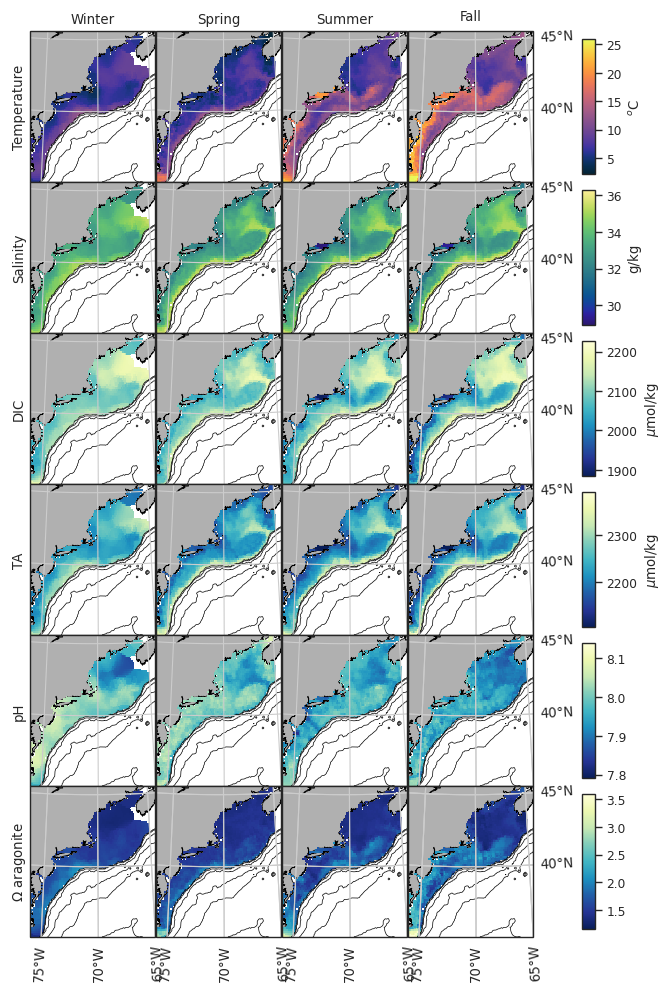

In [14]:
fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(6.5, 12), subplot_kw={'projection':proj})
fig.subplots_adjust(hspace=0, wspace=0)
for ax in axs.ravel():
    ax.set_extent([minlon,maxlon,minlat,maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, [-5000, -4000, -3000, -2000, -1000, -600],
                   colors='k', linewidths=0.5, transform=ccrs.PlateCarree())

for s in range(4):
    tem = axs[0,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.Temperature.isel(season=s),
                              vmin=2.1, vmax=26, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
    sal = axs[1,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.Salinity.isel(season=s),
                              vmin=28.9, vmax=36.3, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())
    dic = axs[2,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.DIC.isel(season=s),
                              vmin=1883.1, vmax=2227.85, cmap=cmap, transform=ccrs.PlateCarree())
    ta  = axs[3,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.TA.isel(season=s),
                              vmin=2102, vmax=2392.93, cmap=cmap, transform=ccrs.PlateCarree())
    ph  = axs[4,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.pH.isel(season=s),
                              vmin=7.79, vmax=8.14, cmap=cmap, transform=ccrs.PlateCarree())
    oa  = axs[5,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.saturation_aragonite.isel(season=s),
                              vmin=1.15, vmax=3.6, cmap=cmap, transform=ccrs.PlateCarree())
    # print(oa.get_clim())

# add colorbars
units = [r'$^o$C', 'g/kg', r'$\mu$mol/kg', r'$\mu$mol/kg', '', '']
for ax, pm, u in zip(axs[:,3], [tem, sal, dic, ta, ph, oa], units):
    l, b, w, h = ax.get_position().bounds
    cax = fig.add_axes([l+w+0.075, b+0.05*h, 0.02, h*0.9])
    cb = fig.colorbar(pm, cax=cax)
    cb.set_label(u)

for ax, title in zip(axs[0,:], ['Winter', 'Spring', 'Summer', 'Fall']):
    ax.set_title(title)

for ax, label in zip(axs[:,0], ['Temperature', 'Salinity', 'DIC', 'TA', 'pH', r'$\Omega$ aragonite']):
    ax.text(-0.085, 0.5, label, ha='center', va='center', rotation=90, transform=ax.transAxes)

for ax in axs[:,3]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})
    
for ax in axs[5,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})
    
fig.savefig('figures/bgc_bottom_seasonal.png', dpi=dpi, bbox_inches='tight')

### Surface - Bottom

In [15]:
ds_diff = ds_surface - ds_bottom

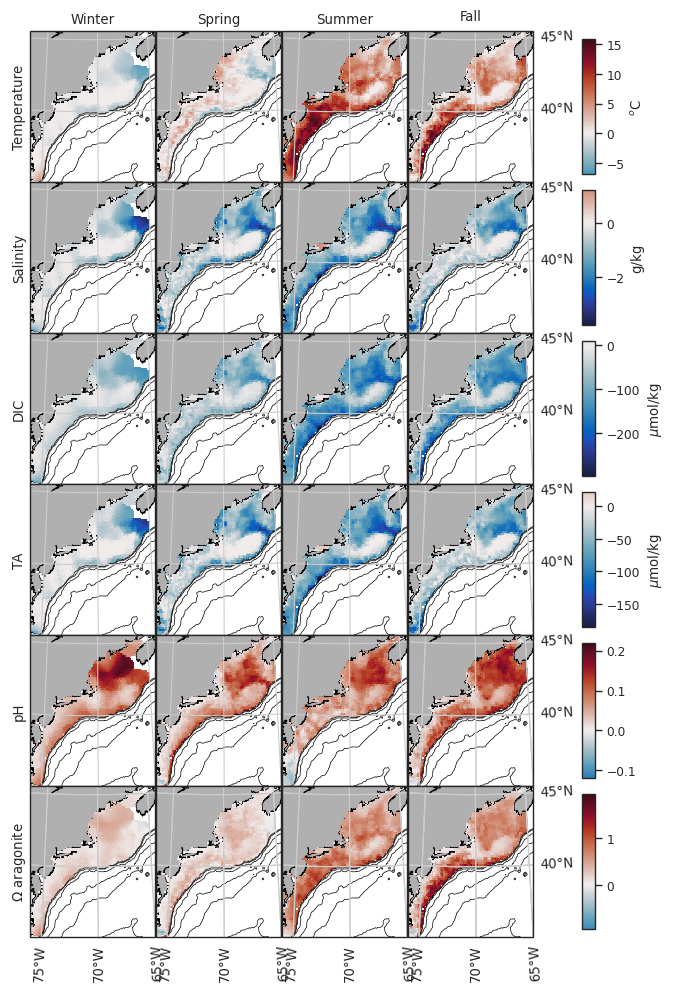

In [16]:
from matplotlib import colors
from mpl_utils import center_cmap

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(6.5, 12), subplot_kw={'projection':proj})
fig.subplots_adjust(hspace=0, wspace=0)
for ax in axs.ravel():
    ax.set_extent([minlon,maxlon,minlat,maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, [-5000, -4000, -3000, -2000, -1000, -600],
                   colors='k', linewidths=0.5, transform=ccrs.PlateCarree())

for s in range(4):
    tem = axs[0,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.Temperature.isel(season=s),
                              vmin=-7, vmax=16, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    sal = axs[1,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.Salinity.isel(season=s),
                              vmin=-3.8, vmax=1.23, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    dic = axs[2,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.DIC.isel(season=s),
                              vmin=-299, vmax=11.15, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    ta  = axs[3,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.TA.isel(season=s),
                              vmin=-185.9, vmax=22.76, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    ph  = axs[4,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.pH.isel(season=s),
                              vmin=-0.12, vmax=0.22, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    oa  = axs[5,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.saturation_aragonite.isel(season=s),
                              vmin=-0.96, vmax=1.96, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    # print(oa.get_clim())
    for pm in [tem, sal, dic, ta, ph, oa]:
        center_cmap(pm)

# add colorbars
units = [r'$^o$C', 'g/kg', r'$\mu$mol/kg', r'$\mu$mol/kg', '', '']
for ax, pm, u in zip(axs[:,3], [tem, sal, dic, ta, ph, oa], units):
    l, b, w, h = ax.get_position().bounds
    cax = fig.add_axes([l+w+0.075, b+0.05*h, 0.02, h*0.9])
    cb = fig.colorbar(pm, cax=cax)
    cb.set_label(u)

for ax, title in zip(axs[0,:], ['Winter', 'Spring', 'Summer', 'Fall']):
    ax.set_title(title)

for ax, label in zip(axs[:,0], ['Temperature', 'Salinity', 'DIC', 'TA', 'pH', r'$\Omega$ aragonite']):
    ax.text(-0.085, 0.5, label, ha='center', va='center', rotation=90, transform=ax.transAxes)

for ax in axs[:,3]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})
    
for ax in axs[5,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})
    
fig.savefig('figures/bgc_difference_seasonal.png', dpi=dpi, bbox_inches='tight')